# Paired Token Prediction

This blog/notebook/pub details a quick analysis we performed on the ESM2 (Evolutionary Scale Modeling) model for masked token prediction. We stumbled upon a counter-intuitive result related to the effect that masking one residue has on the distribution of another.

Before jumping into our results, let's first establish what masked token prediction is, how it works, and our consequent motivation for this analysis.

## Brief primer

At its core, masked token prediction is a way to train and use language models on protein sequences. The basic idea is simple: take a protein sequence, hide some of its amino acids (by replacing them with a special "mask" token), and ask the model to predict what amino acids should go in those masked positions. It's basically a fill-in-the-blanks problem. This approach has proven remarkably effective at capturing the underlying patterns and dependencies in protein sequences.

When doing masked token prediction using an already trained model (like the ESM2 suite), the procedure goes like this. An incomplete sequence is passed through the model. It's incomplete because at one or more residues, a masked token is placed in lieu of an amino acid. The collection of masked positions is denoted as $M$ and the partially masked sequence is denoted as $S_{-M}$. Here's an example:

$$
S_{-M} = \text{A R <mask> A D I <mask>}
$$

Here, $M = \lbrace 2, 6 \rbrace$, which is $0$-indexed because Python has corrupted our minds. When this sequence is passed through an ESM model with an attached language-modelling head, the output is an array of unnormalized probabilities for each amino acid at the masked positions. We call these values *logits*, which can be readily converted into an amino acid probabilities for each masked residue. The amino acid probability distribution of the $i^\text{th}$ residue is denoted as $p(i|M)$, where $i \in M$.

## Motivation

With this understanding of masked token prediction in place, we can explore an important tradeoff in how these predictions are made. When performing masked token prediction, there is a balance between efficiency and information utilization. On one extreme, you could take $S_{-M}$, pass it through the model once, and then unmask each masked token. This would be very computationally efficient. However, this approach precludes the model from leveraging the information gained from each newly unmasked position to inform subsequent predictions. At the other end of the spectrum, you could unmask tokens one at a time: predict the first position, update the sequence with that prediction, pass the updated sequence through the model again to predict the second position, and so on. This iterative approach allows for maximum information utilization but can be really expensive in terms of computational resources. There is also a concern that by unmasking individually, you only make conservative choices that prevent a deeper exploration of sequence space.

All this is to say that developing effective unmasking strategies is an important concern for maximizing the utility of masked-token prediction models. And to do that, it's worth gaining some insight into how masking at one position affects the outcome at another masked position. Our analysis approaches this question by masking two locations, both individually and jointly, and quantifying any changes in their predicted amino acid probabilities. Specifically, we'll consider a pair of positions $i$ and $j$ and ask:

1. How does $p(i | \lbrace i \rbrace)$ compare with $p(i | \lbrace i, j \rbrace)$?
2. How does $p(j | \lbrace j \rbrace)$ compare with $p(j | \lbrace i, j \rbrace)$?

By doing this repeatedly for each pair of residues in the sequence, will we start to capture interdependencies between the sequence positions? Do these statistical dependencies relate back to things we expect, like the attention map of the model, or perhaps the contact map of the amino acids in 3D space? Are there any interpretable patterns at all? We will assess the similarity of these distributions with Jensen-Shannon entropy to find out.

## Loading the model

A good place to start is a quick survey of the available ESM2 model sizes. The ESM2 architecture was created and trained for 6 different model sizes, which are described here:

In [22]:
from analysis.utils import ModelName

for model in ModelName:
    print(model)

ModelName.ESM2_8M
ModelName.ESM2_35M
ModelName.ESM2_150M
ModelName.ESM2_650M
ModelName.ESM2_3B
ModelName.ESM2_15B


All of these models are hosted on [HuggingFace](https://huggingface.co/docs/transformers/en/model_doc/esm) and can be loaded using the `transformers` python package.

The larger models need GPUs to run. We'll do that later. For now, let's load up the smallest model for prototyping the analysis.

In [23]:
from transformers import EsmForMaskedLM

model = EsmForMaskedLM.from_pretrained(ModelName.ESM2_8M.value)
model

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

In addition to the base ESM architecture, this model has an attached language-model decoder head, which you can see at the bottom of the printed model architecture. It is this part of the model that converts the latent embedding produced by the model into the logits array which we will then transform into amino acid probability distributions.

## Getting the probability array $P$

A forward pass of `model` yields a [logits array](https://wandb.ai/amanarora/Written-Reports/reports/Understanding-Logits-Sigmoid-Softmax-and-Cross-Entropy-Loss-in-Deep-Learning--Vmlldzo0NDMzNTU3). That's not quite the array of amino acid probability distributions ($P$) that we desire, but it can be transformed quite simply. You just need to subset the logits array to indices corresponding to amino acids and then take a [softmax](https://en.wikipedia.org/wiki/Softmax_function). Here's the code to do that.

In [25]:
import torch
from analysis.utils import amino_acids
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    ModelName.ESM2_8M.value, clean_up_tokenization_spaces=True
)
aa_token_indices = tokenizer.convert_tokens_to_ids(amino_acids)


def get_probs_array(logits):
    """Given a logits array, return an amino acid probability distribution array.

    Args:
        logits:
            The output from the language-modelling head of an ESM2 model. Shape is (batch_size, seq_len, vocab_size).

    Returns:
        A probability array. Shape is (batch_size, seq_len, 20).
    """
    # Only include tokens that correspond to amino acids. This excludes special, non-amino acid tokens.
    logits_subset = torch.tensor(logits)[..., aa_token_indices]

    return torch.nn.functional.softmax(logits_subset, dim=-1).numpy()

As a sanity check, let's create a sequence of repeating leucines. Then we'll mask one of the residues, and see what the model predicts at that position. Although there is no theoretically "correct" answer for what the model should predict, given that the entire sequence is homogenously leucine, it would be bizarre if the model predicted anything but.

In [27]:
import numpy as np

# Create a sequence of all leucine, then tokenize it.
sequence = "L" * 200
tokenized = tokenizer([sequence], return_tensors="pt")

# Place a mask token in the middle of the tokenized sequence.
mask_pos = 100
tokenized["input_ids"][0, mask_pos] = tokenizer.mask_token_id

# Pass the output of the model through our `get_probs_array` function.
logits_array = model(**tokenized).logits  # Shape (batch_size=1, seq_len=202, vocab_size=33)
probs_array = get_probs_array(logits_array)  # Shape (batch_size=1, seq_len=202, vocab_size=20)

# We are only interested in the position we masked, so let's subset to that.
# Note that the position is indexed with `mask_pos + 1` because of a preceding "CLS"
# token that prefixes the tokenized sequence.
probs_array_at_mask = probs_array[0, mask_pos + 1, :]

# Like a probability distribution should, the elements sum to one (or very nearly)
assert np.isclose(probs_array_at_mask.sum().item(), 1.0)

probs = dict(zip(amino_acids, probs_array_at_mask, strict=False))
probs = dict(
    sorted(((aa, prob.item()) for aa, prob in probs.items()), key=lambda x: x[1], reverse=True)
)
probs

/var/folders/v4/q0wyvpsj4h901lfkjcln68nw0000gn/T/ipykernel_22872/3204031779.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits_subset = torch.tensor(logits)[..., aa_token_indices]


{'L': 0.9906150102615356,
 'P': 0.0018511262023821473,
 'I': 0.001022320706397295,
 'S': 0.0009880419820547104,
 'T': 0.000935297051910311,
 'R': 0.000911062816157937,
 'A': 0.0007281096768565476,
 'V': 0.0007151682511903346,
 'F': 0.00041658783447928727,
 'Q': 0.00030291604343801737,
 'H': 0.00027206382947042584,
 'Y': 0.0002498519897926599,
 'D': 0.00023562906426377594,
 'G': 0.00021731214656028897,
 'M': 0.00014728902897331864,
 'K': 0.00014256870781537145,
 'E': 0.00011488977906992659,
 'N': 5.982790025882423e-05,
 'W': 5.663776028086431e-05,
 'C': 1.8407274183118716e-05}

Encouragingly, the elements sum to one and the model confidently (>99%) predicts leucine.

## Sequence of interest

Now let's introduce a real protein to work with. Any protein will do, really, but we've been exploring the use of [adenosine deaminase (human)](https://www.uniprot.org/uniprotkb/P00813/entry) as a template for protein design, so we've decided to use that.

In [28]:
from pathlib import Path

from biotite.sequence.io.fasta import FastaFile

sequence_path = Path("input/P00813.fasta")
sequence = FastaFile().read(sequence_path)["P00813"]
print(f"{sequence=}")
print(f"{len(sequence)=}")

sequence='MAQTPAFDKPKVELHVHLDGSIKPETILYYGRRRGIALPANTAEGLLNVIGMDKPLTLPDFLAKFDYYMPAIAGCREAIKRIAYEFVEMKAKEGVVYVEVRYSPHLLANSKVEPIPWNQAEGDLTPDEVVALVGQGLQEGERDFGVKARSILCCMRHQPNWSPKVVELCKKYQQQTVVAIDLAGDETIPGSSLLPGHVQAYQEAVKSGIHRTVHAGEVGSAEVVKEAVDILKTERLGHGYHTLEDQALYNRLRQENMHFEICPWSSYLTGAWKPDTEHAVIRLKNDQANYSLNTDDPLIFKSTLDTDYQMTKRDMGFTEEEFKRLNINAAKSSFLPEDEKRELLDLLYKAYGMPPSASAGQNL'
len(sequence)=363


## Creating the mask libraries

We now know how to turn the model output, a logits array, into an array of amino acid probability distributions, marking the launch point for our comparison of amino acid probability distributions for single- versus double-residue masking. We'll do this exhaustively for our sequence of interest by establishing two different libraries: the single masks, of which there are $N$, and the double masks, of which there are $N \choose 2$.

In [29]:
from itertools import combinations

N = len(sequence)
single_masks = list(combinations(range(N), 1))
double_masks = list(combinations(range(N), 2))

print(f"{single_masks[:5]=}")
print(f"{double_masks[:5]=}")

assert len(single_masks) == N
assert len(double_masks) == N * (N - 1) / 2

single_masks[:5]=[(0,), (1,), (2,), (3,), (4,)]
double_masks[:5]=[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]


## Calculating all the logits

This is the compute-heavy portion of the analysis and the details are important, but the code is a little bit complicated so we've tucked away the implementation details into a separate module that's imported below. You can find that module [here](), but here's the TLDR:

We're using [Modal](https://modal.com/)'s cloud infrastructure to distribute our computations across GPUs of varying power (from T4s to H100s). For each model in our analysis, we predict logits arrays twice: once for the single mask library, and again for the double mask library. The computation becomes increasingly demanding with larger models - ESM2-8M costs just pennies to run, while ESM2-15B costs around $30 due to its need for more powerful GPUs and smaller batch sizes. All of this behavior is encapsulated in the `calculate_or_load_logits` function imported below.

If you're following along on your own computer, don't worry - the logits are tracked in the GitHub repository, so the function call below will simply load pre-computed logits from disk without requiring Modal or GPU access.

In [30]:
from analysis.logits import LogitsConfig, calculate_or_load_logits

config = LogitsConfig(
    sequence=sequence,
    single_masks=single_masks,
    double_masks=double_masks,
    single_logits_path=Path("output/logits_single.npz"),
    double_logits_path=Path("output/logits_double.npz"),
)

single_logits, double_logits = calculate_or_load_logits(config)

Single mask library already loaded for facebook/esm2_t6_8M_UR50D. Skipping.
Double mask library already loaded for facebook/esm2_t6_8M_UR50D. Skipping.
Single mask library already loaded for facebook/esm2_t12_35M_UR50D. Skipping.
Double mask library already loaded for facebook/esm2_t12_35M_UR50D. Skipping.
Single mask library already loaded for facebook/esm2_t30_150M_UR50D. Skipping.
Double mask library already loaded for facebook/esm2_t30_150M_UR50D. Skipping.
Single mask library already loaded for facebook/esm2_t33_650M_UR50D. Skipping.
Double mask library already loaded for facebook/esm2_t33_650M_UR50D. Skipping.
Single mask library already loaded for facebook/esm2_t36_3B_UR50D. Skipping.
Double mask library already loaded for facebook/esm2_t36_3B_UR50D. Skipping.
Single mask library already loaded for facebook/esm2_t48_15B_UR50D. Skipping.
Double mask library already loaded for facebook/esm2_t48_15B_UR50D. Skipping.


## Conversion to amino acid probabilities

We've already written a method to convert logits to amino acid probabilties, so let's go ahead and run that conversion for all the data.

In [32]:
single_probs: dict[ModelName, np.ndarray] = {}
double_probs: dict[ModelName, np.ndarray] = {}

for model in ModelName:
    single_probs[model] = get_probs_array(single_logits[model])
    double_probs[model] = get_probs_array(double_logits[model])

## Calculating probability metrics for each residue pair

With that, we finally have amino acid probability distributions for **(a)** each individually masked residue and **(b)** every pairwise combination of doubly-masked residues.

As a reminder, we're interested in comparing $p(i | \lbrace i \rbrace)$ to $p( i | \lbrace i, j \rbrace)$ and $p(j | \lbrace j \rbrace)$ to $p( j | \lbrace i, j \rbrace)$. To compare the degree of similarity between probability distributions, we're going to use [Jenson-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) (JS) using the base-2 logarithm, so that $0$ corresponds to identical distributions and $1$ corresponds to maximally diverged distributions. Our original idea was to use Kullback-Leibler divergence, but it's not symmetric, which JS divergence was developed to resolve.

Since we'll have to loop through each residue pair to calculate the JS divergence, it may be useful to calculate some other metrics along the way. Here's a summary of the metrics we'll calculate and construct a dataframe from.

* `position_i`: The $i^{\text{th}}$ residue position.
* `position_j`: The $j^{\text{th}}$ th residue position.
* `amino_acid_i`: The original amino acid at the $i^{\text{th}}$ residue.
* `most_probable_i_i`: The amino acid with the highest probability in $p(i | \lbrace i \rbrace)$.
* `most_probable_i_ij`: The amino acid with the highest probability in $p( i | \lbrace i, j \rbrace)$.
* `amino_acid_j`: The original amino acid at the $j^{\text{th}}$ residue.
* `most_probable_j_j`: The amino acid with the highest probability in $p(j | \lbrace j \rbrace)$.
* `most_probable_j_ij`: The amino acid with the highest probability in $p( j | \lbrace i, j \rbrace)$.
* `perplex_i_i`: The perplexity of $p(i | \lbrace i \rbrace)$.
* `perplex_i_ij`: The perplexity of $p( i | \lbrace i, j \rbrace)$.
* `perplex_j_i`: The perplexity of $p(j | \lbrace j \rbrace)$.
* `perplex_j_ij`: The perplexity of $p( j | \lbrace i, j \rbrace)$.
* `js_div_i`: The Jenson-Shannon divergence between $p(i | \lbrace i \rbrace)$ and $p( i | \lbrace i, j \rbrace)$.
* `js_div_j`: The Jenson-Shannon divergence between $p(j | \lbrace j \rbrace)$ and $p( j | \lbrace i, j \rbrace)$.
* `js_div_avg`: `(js_div_i + js_div_j) / 2`.

In [33]:
import pandas as pd
from analysis.residue_pair_data import calculate_pairwise_data

pairwise_data: dict[ModelName, pd.DataFrame] = {}

for model_name in ModelName:
    pairwise_dataframe = calculate_pairwise_data(
        sequence=sequence,
        single_probs=single_probs[model_name],
        double_probs=double_probs[model_name],
        double_masks=double_masks,
    )
    pairwise_data[model_name] = pairwise_dataframe

/opt/miniconda3/envs/paired-token-masking/lib/python3.12/site-packages/scipy/spatial/distance.py:1271: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


`pairwise_data` is a dictionary that holds all the residue pair data for each model. Let's inspect the first few entries for the largest model.

In [34]:
pairwise_15b = pairwise_data[ModelName.ESM2_15B]
pairwise_15b.head(15)

position_i  position_j amino_acid_i most_probable_i_i most_probable_i_ij  \
0            0           1            M                 M                  M   
1            0           2            M                 M                  M   
2            0           3            M                 M                  M   
3            0           4            M                 M                  M   
4            0           5            M                 M                  M   
5            0           6            M                 M                  M   
6            0           7            M                 M                  M   
7            0           8            M                 M                  M   
8            0           9            M                 M                  M   
9            0          10            M                 M                  M   
10           0          11            M                 M                  M   
11           0          12            M                 M                  M   
12           0          13            M                 M                  M   
13           0          14            M                 M                  M   
14           0          15            M                 M                  M   

   amino_acid_j most_probable_j_j most_probable_j_ij  perplex_i_i  \
0             A                 A                  A     1.874111   
1             Q                 Q                  Q     1.874111   
2             T                 T                  T     1.874111   
3             P                 P                  P     1.874111   
4             A                 A                  A     1.874111   
5             F                 F                  F     1.874111   
6             D                 N                  N     1.874111   
7             K                 K                  K     1.874111   
8             P                 P                  P     1.874111   
9             K                 K                  K     1.874111   
10            V                 V                  V     1.874111   
11            E                 E                  E     1.874111   
12            L                 L                  L     1.874111   
13            H                 H                  H     1.874111   
14            V                 V                  V     1.874111   

    perplex_i_ij  perplex_j_j  perplex_j_ij  js_div_i  js_div_j  js_div_avg  
0       1.742441     3.191700      2.850710  0.084210  0.089429    0.086820  
1       1.664312     2.018497      1.940485  0.045490  0.015094    0.030292  
2       1.743261     3.114773      2.992301  0.025954  0.030157    0.028055  
3       2.434045     1.156383      1.146090  0.092536  0.005108    0.048822  
4       1.830846     2.304582      2.197421  0.015346  0.016212    0.015779  
5       2.209931     1.022100      1.022258  0.054045  0.000387    0.027216  
6       1.505097     2.338731      2.304871  0.076173  0.011904    0.044038  
7       2.090936     1.117977      1.115108  0.035277  0.001756    0.018517  
8       1.789863     1.011045      1.011041  0.019306  0.000541    0.009923  
9       1.814933     1.004055      1.004027  0.014234  0.000131    0.007182  
10      1.806835     1.010202      1.009831  0.013467  0.000729    0.007098  
11      2.034674     1.007552      1.007449  0.030276  0.000228    0.015252  
12      1.996381     1.001015      1.001023  0.022350  0.000096    0.011223  
13      1.961379     1.001065      1.001084  0.015931  0.000080    0.008005  
14      2.140735     1.053767      1.053413  0.042064  0.001756    0.021910

Before we compare single- to double-masking results, let's see what the reconstruction accuracy is for the protein.


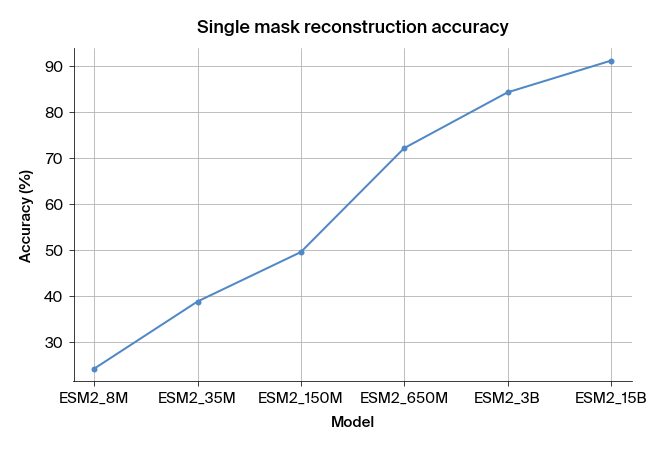

In [100]:
import arcadia_pycolor as apc
import matplotlib.pyplot as plt

apc.mpl.setup()


def get_recon_acc(df: pd.DataFrame) -> float:
    matches = df["most_probable_i_i"] == df["amino_acid_i"]
    return 100 * matches.sum() / len(matches)


plt.figure(figsize=(10, 6))
plt.plot(
    [model.name for model in ModelName],
    [get_recon_acc(pairwise_data[model]) for model in ModelName],
    marker="o",
    linestyle="-",
)
plt.title("Single mask reconstruction accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

Relatedly, the model confidence is quite high, as measured via average perplexity:

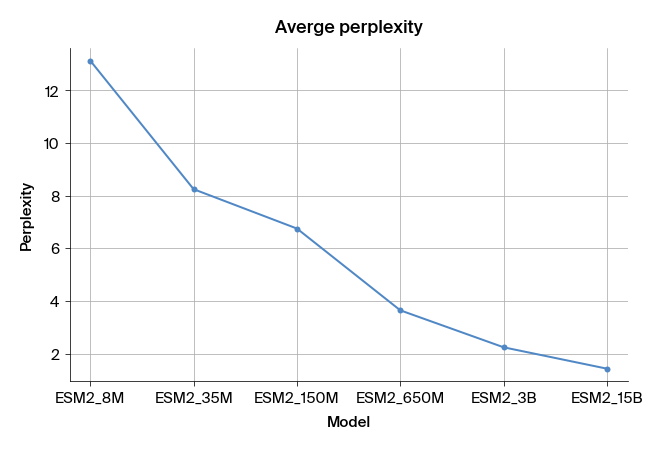

In [104]:
def avg_perplexity(df: pd.DataFrame) -> float:
    return df.perplex_i_i.mean()


plt.figure(figsize=(10, 6))
plt.plot(
    [model.name for model in ModelName],
    [avg_perplexity(pairwise_data[model]) for model in ModelName],
    marker="o",
    linestyle="-",
)
plt.title("Averge perplexity")
plt.xlabel("Model")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

## The effects of single- versus double-masking

In the single-masking case, the model has access to all context except the masked token $i$. However, in double-masking, the model loses access to both tokens $i$ and $j$, reducing the available context for making predictions. This reduction in context should lead to greater uncertainty in the model's predictions. We can quantify this uncertainty using perplexity. Our hypothesis is that $p(i | \lbrace i,j \rbrace)$ will show higher perplexity than $p(i | \lbrace i \rbrace)$ because **(1)** the model has less contextual information to work with and **(2)** the presence of multiple masks creates more ambiguity about the relationships between the masked tokens.

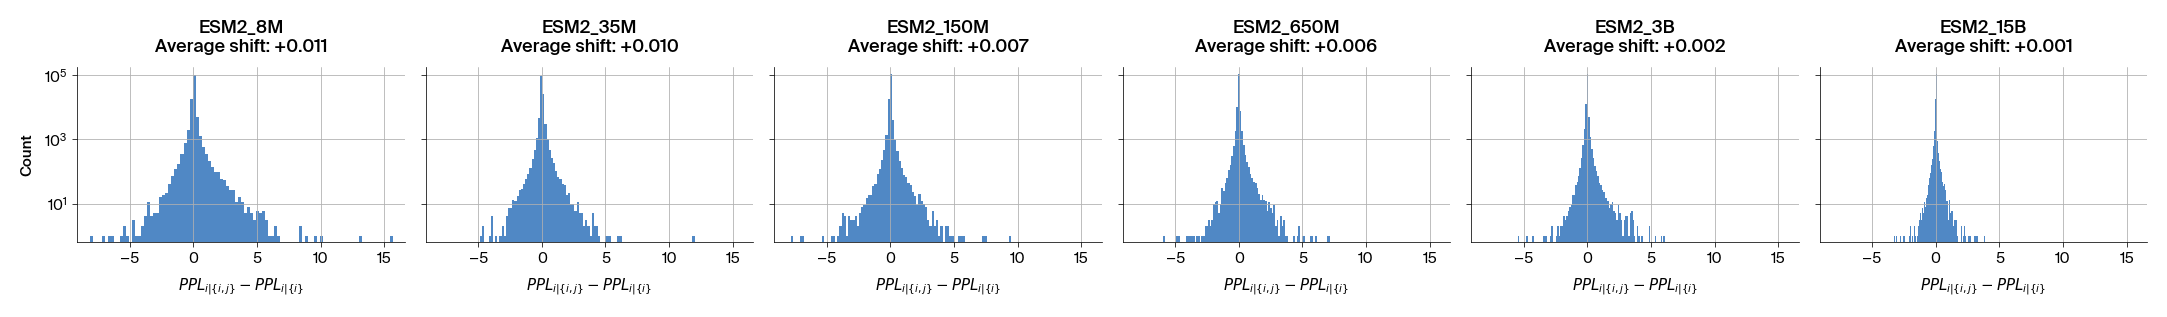

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(
    1, len(ModelName), figsize=(5 * len(ModelName), 4.3), sharey=True, sharex=True
)

for ax, model in zip(axes, ModelName, strict=True):
    df = pairwise_data[model]
    diff = df["perplex_i_ij"] - df["perplex_i_i"]
    ax.grid(True)
    ax.hist(diff, bins=100, edgecolor="black")
    ax.set_title(f"{model.name}\nAverage shift: +{diff.mean():.3f}")
    ax.set_xlabel(r"$ PPL_{i| \lbrace i, j \rbrace} - PPL_{i| \lbrace i \rbrace} $")
    ax.set_yscale("log")
    if ax == axes[0]:
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

While the results show that there is on average a very slight shift for higher perplexity when double-masking, the effect is *very* slight. These data illustrate that amino acid prediction probabilities are on average independent from each other between the single- and double-masked libraries--especially for the larger models.

However, these averages might mask important position-specific dependencies. Even if masking residue $j$ typically has little effect on predicting residue $i$, there could be specific pairs of positions where masking $j$ substantially impacts the prediction of residue $i$. To identify the extent of these position pairs, we can examine a more targeted metric: for each position $i$, what is the maximum increase in perplexity caused by masking any other position $j$? This analysis will help reveal whether certain amino acid positions have strong dependencies that are hidden when looking at average effects.

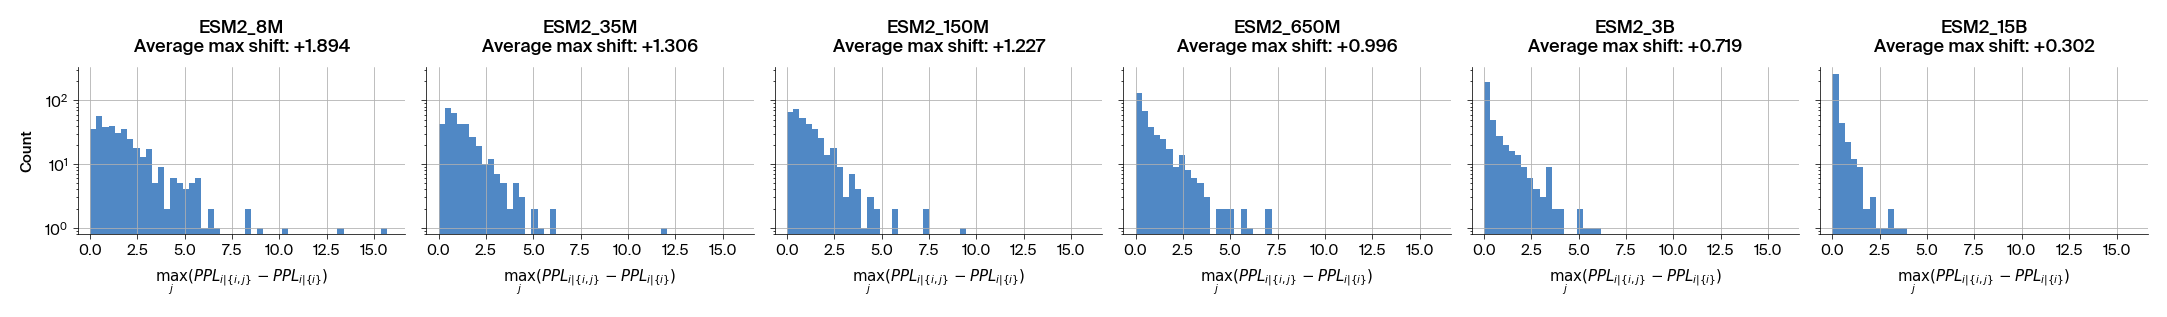

In [101]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(
    1, len(ModelName), figsize=(5 * len(ModelName), 4.3), sharey=True, sharex=True
)
for ax, model in zip(axes, ModelName, strict=True):
    df = pairwise_data[model]

    df["diff"] = df["perplex_i_ij"] - df["perplex_i_i"]
    diff = df.groupby("position_i")["diff"].max()

    ax.grid(True)
    ax.hist(diff, bins=np.linspace(0, 16, 50), edgecolor="black")
    ax.set_title(f"{model.name}\nAverage max shift: +{diff.mean():.3f}")
    ax.set_xlabel(r"$ \max_j(PPL_{i| \lbrace i, j \rbrace} - PPL_{i| \lbrace i \rbrace}) $")
    ax.set_yscale("log")
    if ax == axes[0]:
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

These position-specific maximum shifts show that while random position pairs on average share little dependence, for any given position $i$ there tends to exist at least one position $j$ that noticeably impacts the model's confidence in predicting $i$. Even in the 15B parameter model, which has an average perplexity of less than 2, double-masking can significantly perturb perplexity. To understand the magnitude of this effect in practical terms, let's see whether $p(i | \lbrace i \rbrace)$ and $p(i | \lbrace i,j \rbrace)$ ever predict different amino acids as most probable, as that would indicate positions where context truly alters the model's understanding of the protein sequence, rather than just lowering its confidence.

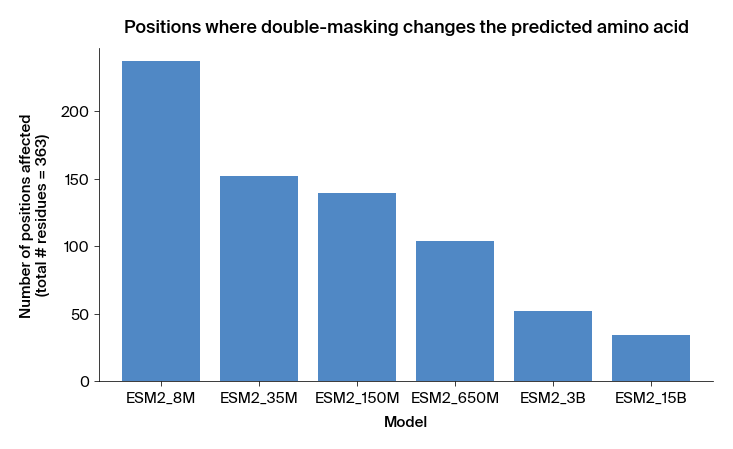

In [116]:
import matplotlib.pyplot as plt
import numpy as np

aa_changes = []
for model in ModelName:
    df = pairwise_data[model]
    df["matches"] = df["most_probable_i_i"] != df["most_probable_i_ij"]
    aa_change = df.groupby("position_i")["matches"].any().sum()
    aa_changes.append(aa_change)

plt.figure(figsize=(11, 6))
plt.bar(
    [model.name for model in ModelName],
    aa_changes,
)
plt.title("Positions where double-masking changes the predicted amino acid")
plt.xlabel("Model")
plt.ylabel(f"Number of positions affected\n(total # residues = {len(sequence)})")
plt.show()

Let me revise to better connect these ideas and maintain a clearer analytical flow:
In the largest model, more than 10% of positions have at least one partner position whose masking changes which amino acid is predicted as most likely. While this reveals clear cases of strong positional dependence, it only captures the most extreme effects - cases where context actually shifts the model's top prediction. To capture more subtle interactions, where masking position $j$ meaningfully shifts the probability distribution at position $i$ without necessarily changing the most likely amino acid, we finally arrive at Jensen-Shannon (JS) divergence.

## Visualizing Shannon-Jensen divergence

The relationships between all pairs of positions can be effectively visualized using heatmaps, where each cell $(i,j)$ shows the JS divergence between $p(i|{i})$ and $p(i|{i,j})$. These heatmaps reveal the full spectrum of positional dependencies, from subtle probability shifts to the dramatic changes we observed in top predictions, potentially even highlighting familiar biologically relationships between positions.

With that in mind, below is a series of heatmaps for the average Jenson-Shannon divergence, with increasing model size.

Note: since plotting code isn't very informative, we've buried it in a module that we'll simply import below. But keep in mind this whole project, including the plotting code, is at [your fingertips](https://github.com/Arcadia-Science/2024-paired-token-masking).

In [117]:
import analysis.plotting as plotting


def get_js_div_matrix(df: pd.DataFrame) -> np.ndarray:
    indices = sorted(set(df["position_i"]).union(df["position_j"]))
    matrix = pd.DataFrame(index=indices, columns=indices)  # type: ignore

    for _, row in df.iterrows():
        matrix.at[row.position_i, row.position_j] = row.js_div_avg
        matrix.at[row.position_j, row.position_i] = row.js_div_avg

    np.fill_diagonal(matrix.values, np.nan)

    matrix_values = matrix.to_numpy()
    return matrix_values.astype(np.float32)


for model in ModelName:
    plotting.visualize_js_div_matrix(get_js_div_matrix(pairwise_data[model]), title=model)

ValueError: 
    Invalid value of type 'analysis.utils.ModelName' received for the 'title' property of layout
        Received value: <ModelName.ESM2_8M: 'facebook/esm2_t6_8M_UR50D'>

    The 'title' property is an instance of Title
    that may be specified as:
      - An instance of :class:`plotly.graph_objs.layout.Title`
      - A dict of string/value properties that will be passed
        to the Title constructor

        Supported dict properties:
            
            automargin
                Determines whether the title can automatically
                push the figure margins. If `yref='paper'` then
                the margin will expand to ensure that the title
                doesn’t overlap with the edges of the
                container. If `yref='container'` then the
                margins will ensure that the title doesn’t
                overlap with the plot area, tick labels, and
                axis titles. If `automargin=true` and the
                margins need to be expanded, then y will be set
                to a default 1 and yanchor will be set to an
                appropriate default to ensure that minimal
                margin space is needed. Note that when
                `yref='paper'`, only 1 or 0 are allowed y
                values. Invalid values will be reset to the
                default 1.
            font
                Sets the title font. Note that the title's font
                used to be customized by the now deprecated
                `titlefont` attribute.
            pad
                Sets the padding of the title. Each padding
                value only applies when the corresponding
                `xanchor`/`yanchor` value is set accordingly.
                E.g. for left padding to take effect, `xanchor`
                must be set to "left". The same rule applies if
                `xanchor`/`yanchor` is determined
                automatically. Padding is muted if the
                respective anchor value is "middle*/*center".
            subtitle
                :class:`plotly.graph_objects.layout.title.Subti
                tle` instance or dict with compatible
                properties
            text
                Sets the plot's title. Note that before the
                existence of `title.text`, the title's contents
                used to be defined as the `title` attribute
                itself. This behavior has been deprecated.
            x
                Sets the x position with respect to `xref` in
                normalized coordinates from 0 (left) to 1
                (right).
            xanchor
                Sets the title's horizontal alignment with
                respect to its x position. "left" means that
                the title starts at x, "right" means that the
                title ends at x and "center" means that the
                title's center is at x. "auto" divides `xref`
                by three and calculates the `xanchor` value
                automatically based on the value of `x`.
            xref
                Sets the container `x` refers to. "container"
                spans the entire `width` of the plot. "paper"
                refers to the width of the plotting area only.
            y
                Sets the y position with respect to `yref` in
                normalized coordinates from 0 (bottom) to 1
                (top). "auto" places the baseline of the title
                onto the vertical center of the top margin.
            yanchor
                Sets the title's vertical alignment with
                respect to its y position. "top" means that the
                title's cap line is at y, "bottom" means that
                the title's baseline is at y and "middle" means
                that the title's midline is at y. "auto"
                divides `yref` by three and calculates the
                `yanchor` value automatically based on the
                value of `y`.
            yref
                Sets the container `y` refers to. "container"
                spans the entire `height` of the plot. "paper"
                refers to the height of the plotting area only.


## Comparison to 3D contact map

A striking pattern emerges and interestingly, it is most prominently observed at the intermediately sized 150M model parameter. It looks an awful lot like a structural contact map, so let's load up the structure, calculate the pairwise residue distances, and compare.

In [ ]:
import biotite.structure as struc
from biotite.structure.io import load_structure

# Use alpha carbons
array = load_structure("input/P00813.pdb")
array = array[array.atom_name == "CA"]

distance_map = np.zeros((len(array), len(array)))
for i in range(len(array)):
    distance_map[i, :] = struc.distance(array[i], array)

# Define the contact map as the inverse of the distances
contact_map = 1 / distance_map

/var/folders/v4/q0wyvpsj4h901lfkjcln68nw0000gn/T/ipykernel_5947/242202633.py:13: RuntimeWarning:

divide by zero encountered in divide



We'll plot the JS-divergence for the 150M model on the upper left triangular region of the heatmap and the contact map on the lower right triangular region.

In [ ]:
m150_divergence = get_js_div_matrix(pairwise_data[ModelName.ESM2_150M])
plotting.compare_to_contact_map(m150_divergence, contact_map)

This basically illustrates that there is some pairwise epistasis being captured, whereby masking one residue affects the probability distribution of a second masked residue, and that the strength of this effect inversely correlates with the physical distance between the residues. Given that the attention maps learned in the ESM models recapitulate protein contact maps, seeing this propagate to the logits isn't too surprising. Although, unlike the attention maps, which recapitulate contact maps better and better with increasing model size, the correlation with contact map is strongest in intermediate model sizes.

To quantify this effect, let's calculate a Spearman correlation between the JS divergence and the contact map for each model size. To improve our signal-to-noise ratio, let's exclude any pairwise positions where the contact map was less than the median.

In [111]:
from scipy.stats import spearmanr


def pairwise_spearman(JS, contact_map):
    # Grab upper-triangular of matrices and flatten
    JS = JS[np.triu_indices_from(JS, k=1)]
    contact_map = contact_map[np.triu_indices_from(contact_map, k=1)]

    keep = contact_map > np.median(contact_map)
    return spearmanr(JS[keep], contact_map[keep]).correlation


correlations = [
    pairwise_spearman(get_js_div_matrix(pairwise_data[model]), contact_map)
    for model in ModelName.all()
]

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(
    [model.name for model in ModelName],
    correlations,
    marker="o",
    linestyle="-",
)
plt.title("Spearman Correlation of JS Divergence with Contact Map")
plt.xlabel("Model")
plt.ylabel("Spearman Correlation")
plt.grid(True)
plt.show()

AttributeError: type object 'ModelName' has no attribute 'all'

## Conclusion

The data seems to show that those residues--the ones which induce significant changes in the amino acid probability distributions of all other residues in the protein--are important in the following way: mutate them, and disproportionately alter the model's amino acid preferences at all the other positions. But these residues don't fit the profile for causing dramatic, across-protein consequences. In fact, the evidence suggests they tend to occur at residues exhibiting low conservation.

We are a bit "perplexed" by this result. For us, this exploration has left us with three questions.

1. Why does the contact map pattern diminish in the larger models?
2. Why do the larger models exhibit UA residues?
3. why do these UA residues tend to occur at sites of low conservation?

We're hoping this is where you come in. Do you know the answers to any of these questions, or have any hyotheses? We'd love to hear form you.